In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Ran on Colab for Training

# !pip install -U transformers datasets evaluate accelerate sentencepiece

## Exploratory Data Analysis

In [2]:
# Load ANLI Round 2 splits
ds_train = load_dataset("facebook/anli", split="train_r2")
ds_val   = load_dataset("facebook/anli", split="dev_r2")
ds_test  = load_dataset("facebook/anli", split="test_r2")

print(f"Train: {len(ds_train)},  Dev: {len(ds_val)},  Test: {len(ds_test)}")
print(ds_train.features)

Train: 45460,  Dev: 1000,  Test: 1000
{'uid': Value('string'), 'premise': Value('string'), 'hypothesis': Value('string'), 'label': ClassLabel(names=['entailment', 'neutral', 'contradiction']), 'reason': Value('string')}


In [3]:
# Preview a few samples
for i in range(0,20,4):
    print(f"\nExample {i+1}")
    print("Premise:", ds_train[i]["premise"])
    print("Hypothesis:", ds_train[i]["hypothesis"])
    print("Label:", ds_train.features["label"].int2str(ds_train[i]["label"]))


Example 1
Premise: Topi Raja Sweety Roja is a 1996 Telugu comedy film, produced by Dr. A. Vijayalakshmi on Sri Sai Madhavi Productions banner and directed by Dr. N. Siva Prasad. Starring Rajendra Prasad, Roja in the lead roles and music also composed by "Hero" Rajendra Prasad.
Hypothesis: The lead role was played by Rajendra Prasad
Label: entailment

Example 5
Premise: Nantwich Town Football Club is a semi-professional football club based in Nantwich, Cheshire, England. The club was founded in 1884 and is nicknamed "The Dabbers", a reference to the town's tanning industry. The club is currently a member of the Northern Premier League Premier Division, the seventh tier in the English football league system, with home matches played at the Weaver Stadium.
Hypothesis: Nantwich Town Football plays in the Championship and will soon be promoted to the English Premier League.
Label: contradiction

Example 9
Premise: The Cars are an American rock band that emerged from the new wave scene in t

### Data integrity checks

In [4]:
#Convert to DataFrame
df_train = ds_train.to_pandas()

print(df_train.isna().sum())  # Check for missing values
print("Empty premise:", (df_train["premise"].str.strip() == "").sum())
print("Empty hypothesis:", (df_train["hypothesis"].str.strip() == "").sum())
print("Duplicates:", df_train.duplicated(subset=["premise", "hypothesis"]).sum())

uid           0
premise       0
hypothesis    0
label         0
reason        0
dtype: int64
Empty premise: 0
Empty hypothesis: 0
Duplicates: 31


### Duplicate Analysis

31 duplicate (premise, hypothesis) pairs were detected in the training set.

All duplicates shared identical labels, meaning there was no annotation disagreement.

These duplicates were removed to ensure each example is unique.

The final training set contains 45,429 examples.


In [5]:
dup_mask = df_train.duplicated(subset=["premise", "hypothesis"], keep=False)
duplicates_df = df_train[dup_mask].sort_values(by=["premise", "hypothesis"]).reset_index(drop=True)

print(f"Total duplicates found: {len(duplicates_df)}")
duplicates_df

Total duplicates found: 62


,uid,premise,hypothesis,label,reason
0,91a7b96a-8a76-460c-a973-b10abeccba44,"""I Never Picked Cotton"" is a song made famous ...","""I Never Picked Cotton"" was written by Roy Clark.",2,
1,57916c4e-f8b4-4b53-afab-fb82eed1a92e,"""I Never Picked Cotton"" is a song made famous ...","""I Never Picked Cotton"" was written by Roy Clark.",2,
2,a91a4b08-5be2-4009-8f1b-1c7628c99064,"""Paint It Black"" (originally released as ""Pain...",Paint It Black had a comma in the original name.,0,
3,bb8ef959-2fb2-4d34-8677-218f67962cf8,"""Paint It Black"" (originally released as ""Pain...",Paint It Black had a comma in the original name.,0,"""Paint It Black"" (originally released as ""Pain..."
4,4869098b-557b-46ac-97e2-6638e0bff125,54-40 is a Canadian alternative rock group fro...,54-40 is a rap group.,2,
...,...,...,...,...,...
57,5e238696-3136-4cdc-9855-e9443c942c80,The Banks Sidewinder is a land speed record ve...,The Banks Sidewinder is the fastest pickup ever.,0,We know the Banks Sidewinder was the fastest i...
58,b0f98bda-d8e1-4c12-83a5-e9b22eb4aaf1,The Sandlot is a 1993 American coming-of-age b...,It was filmed in Utah.,0,
59,d5456dad-388f-4506-a035-241a24474ba0,The Sandlot is a 1993 American coming-of-age b...,It was filmed in Utah.,0,
60,1aac88b7-9183-4759-961c-bb13fe1b9990,Vampire Vs Vampire (一眉道人) is a 1989 Hong Kong ...,Vampire Vs Vampire is funny and scary.,0,


In [6]:
# Drop duplicate (premise, hypothesis) pairs
initial_len = len(df_train)
df_train = df_train.drop_duplicates(subset=["premise", "hypothesis"]).reset_index(drop=True)
print(f"Removed {initial_len - len(df_train)} duplicates.")
print(f"New training set size: {len(df_train)}")

Removed 31 duplicates.
New training set size: 45429


## Label Distribution

/var/folders/xk/v43z00vn3mj3lb_2ryh_5wxm0000gn/T/ipykernel_1103/685009048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label_name", data=df_train, order=label_names, palette="Set2")


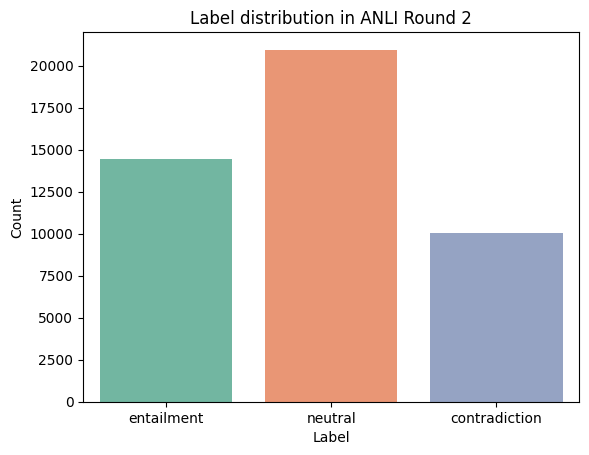

label_name
neutral          0.461137
entailment       0.317705
contradiction    0.221158
Name: proportion, dtype: float64

In [7]:
label_names = ds_train.features["label"].names
df_train["label_name"] = df_train["label"].map(dict(enumerate(label_names)))

sns.countplot(x="label_name", data=df_train, order=label_names, palette="Set2")
plt.title("Label distribution in ANLI Round 2")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

df_train["label_name"].value_counts(normalize=True)

### Label Distribution Analysis

The dataset shows a mild imbalance among the three classes:

| Label | Proportion |
|--------|-------------|
| Neutral | 46.1 % |
| Entailment | 31.8 % |
| Contradiction | 22.1 % |

The **neutral** class dominates slightly, reflecting that many premise–hypothesis pairs in ANLI Round 2
are constructed to be contextually related but not strictly entailed or contradictory.
This slight skew will be accounted for during model evaluation using metrics such as **macro-F1**, which
balances performance across classes.

## Text-length analysis

In [8]:
# Text length analysis
df_train["premise_len"] = df_train["premise"].str.split().str.len()
df_train["hypothesis_len"] = df_train["hypothesis"].str.split().str.len()

df_train[["premise_len", "hypothesis_len"]].describe(percentiles=[.5, .75, .9, .95])

,premise_len,hypothesis_len
count,45429.000000,45429.000000
mean,53.998745,9.954324
std,8.162646,5.336102
min,33.000000,3.000000
50%,54.000000,9.000000
75%,60.000000,11.000000
90%,65.000000,16.000000
95%,67.000000,19.000000
max,76.000000,65.000000


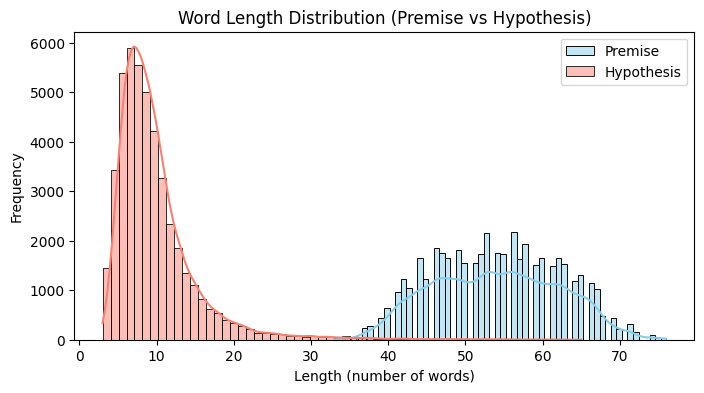

In [9]:
# Word Length analysis
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.histplot(df_train["premise_len"], bins=60, color="skyblue", label="Premise", kde=True)
sns.histplot(df_train["hypothesis_len"], bins=60, color="salmon", label="Hypothesis", kde=True)
plt.legend()
plt.title("Word Length Distribution (Premise vs Hypothesis)")
plt.xlabel("Length (number of words)")
plt.ylabel("Frequency")
plt.show()

### Text Length Summary

| Statistic | Premise | Hypothesis |
|------------|----------|-------------|
| Mean | 54.0 | 10.0 |
| 75th Percentile | 60.0 | 11.0 |
| 95th Percentile | 67.0 | 19.0 |
| Max | 76.0 | 65.0 |

**Interpretation:**  
Premises average around 54 words, while hypotheses average 10 words.  
95 % of combined inputs remain under 86 words, making a tokenizer `max_length` of **256–384 tokens** sufficient for all examples.  
Premises tend to be longer, providing the factual context, whereas hypotheses are concise statements being tested for inference.

### Baseline: TF-IDF + Logistic Regression

A hypothesis-only logistic-regression baseline was trained using TF-IDF unigram + bigram features
(100 K max features).  
This model ignores the premise and predicts labels from the hypothesis text alone,
testing whether superficial lexical cues can solve the task.

**Results (dev set):**
- Accuracy ~= 40 %
- Macro-F1 ~= 0.38

These scores hover near random chance, confirming that ANLI Round 2
successfully removes shallow lexical shortcuts.
Subsequent transformer models will therefore capture deeper semantic reasoning.

In [10]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

# We use only the "hypothesis" column for this baseline, ignoring the premise.
# This creates a hypothesis-only model.

X_train = df_train["hypothesis"]
y_train = df_train["label"]

# Validation data (dev split)
df_val = ds_val.to_pandas()
X_val = df_val["hypothesis"]
y_val = df_val["label"]


# TF-IDF (Term Frequency – Inverse Document Frequency)
# transforms text into weighted numerical features that capture how important each word/bigram is within a sentence relative to the dataset.

tfidf = TfidfVectorizer(
    min_df=3,                # Ignore very rare terms
    max_features=100_000,    # Limit vocabulary size
    ngram_range=(1, 2),      # Include both unigrams and bigrams
    sublinear_tf=True         # Apply log-scaling
)

# Fit on training data and transform both train/validation sets
X_train_vec = tfidf.fit_transform(X_train)
X_val_vec   = tfidf.transform(X_val)


# Train the Logistic Regression classifier

clf = LogisticRegression(
    max_iter=200,       # Max optimization iterations
    solver="lbfgs",     # Quasi-Newton optimizer
    n_jobs=-1
)

# Train the model
clf.fit(X_train_vec, y_train)


# Evaluate on the validation set
# Predict labels for dev data
y_pred = clf.predict(X_val_vec)

# Compute key metrics:
#   Accuracy: overall correct predictions
#   Macro-F1: average F1 across classes (balanced view)
acc = accuracy_score(y_val, y_pred)
macro_f1 = f1_score(y_val, y_pred, average="macro")


# Print evaluation summary
print(f"Validation Accuracy: {acc:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print("\nDetailed classification report:")
print(classification_report(
    y_val, y_pred,
    target_names=ds_val.features["label"].names
))

Validation Accuracy: 0.3950
Macro F1-score: 0.3836

Detailed classification report:
               precision    recall  f1-score   support

   entailment       0.37      0.44      0.40       334
      neutral       0.40      0.52      0.46       333
contradiction       0.42      0.22      0.29       333

     accuracy                           0.40      1000
    macro avg       0.40      0.39      0.38      1000
 weighted avg       0.40      0.40      0.38      1000



### 🎯 Evaluation Metrics Rationale

Since ANLI is a **3-way classification** task with slight class imbalance
(neutral ≈46%, entailment ≈32%, contradiction ≈22%),
we report both overall and class-balanced metrics.

| Metric | Purpose | Rationale |
|---------|----------|-----------|
| **Accuracy** | Measures total correct predictions | Simple global indicator; useful for model comparison |
| **Macro-F1** | Average F1 across all classes equally | Balances performance on frequent and rare classes |
| **Precision / Recall / F1 per class** | Detailed view per label | Reveals which inference types the model handles well or struggles with |

Accuracy alone can be misleading if the model favors one class.
Macro-F1 provides a fair, balanced view, while the detailed class report
highlights strengths (e.g., Neutral) and weaknesses (e.g., Contradiction).

# Transformer model

In [11]:
# Imports, version checks, device, and seeding
import os, random, numpy as np, torch
from datasets import load_dataset, Dataset, Features, Value, ClassLabel
import transformers, datasets

print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)

# Device info
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Reproducibility
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

Transformers: 4.57.1
Datasets: 4.4.1
CUDA available: False


In [12]:
# Build the training Dataset from the cleaned df_train
from datasets import Dataset, Features, Value, ClassLabel, load_dataset

# Load dev/test splits
ds_val  = load_dataset("facebook/anli", split="dev_r2")
ds_test = load_dataset("facebook/anli", split="test_r2")

# Extract label names from dev split 
label_names = ds_val.features["label"].names  # ['entailment','neutral','contradiction']
id2label = {i: n for i, n in enumerate(label_names)}
label2id = {n: i for i, n in enumerate(label_names)}
print("Label mapping:", id2label)
assert {"premise","hypothesis","label"}.issubset(df_train.columns), "df_train missing required columns"

# Define the Hugging Face features schema
features = Features({
    "premise": Value("string"),
    "hypothesis": Value("string"),
    "label": ClassLabel(names=label_names)
})

# Convert DataFrame to Hugging Face Dataset
ds_train = Dataset.from_pandas(df_train[["premise", "hypothesis", "label"]], features=features)

print(f"Train size (cleaned): {len(ds_train)}")
print(f"Dev size: {len(ds_val)} | Test size: {len(ds_test)}")

Label mapping: {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
Train size (cleaned): 45429
Dev size: 1000 | Test size: 1000


In [13]:
# Tokenizer
from transformers import AutoTokenizer

MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LEN = 256   #from EDA (95th percentile)

tok = AutoTokenizer.from_pretrained(MODEL_NAME)

/Users/sanshritbakshi/Desktop/eai-anli-r2/.venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [14]:
# Preprocess data before training.
def preprocess(batch):
    enc = tok(
        batch["premise"],
        batch["hypothesis"],
        truncation=True,
        padding=False,
        max_length=MAX_LEN
    )
    if "label" in batch:
        enc["labels"] = batch["label"]
    return enc

# Column lists
cols_train = ds_train.column_names
cols_val   = ds_val.column_names
cols_test  = ds_test.column_names

# Tokenize + drop raw columns
ds_train_tok = ds_train.map(preprocess, batched=True, remove_columns=cols_train)
ds_val_tok   = ds_val.map(preprocess,   batched=True, remove_columns=cols_val)
ds_test_tok  = ds_test.map(preprocess,  batched=True, remove_columns=cols_test)

# tensor format for PyTorch
ds_train_tok.set_format(type="torch")
ds_val_tok.set_format(type="torch")
ds_test_tok.set_format(type="torch")

# Sanity check
print(ds_train_tok.column_names)
print(ds_train_tok[0].keys())

Map:   0%|          | 0/45429 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

['input_ids', 'token_type_ids', 'attention_mask', 'labels']
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


## Model Training

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
from transformers import EarlyStoppingCallback

# Load evaluation metrics
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

#Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,  # entailment, neutral, contradiction
    id2label={0: "entailment", 1: "neutral", 2: "contradiction"},
    label2id={"entailment": 0, "neutral": 1, "contradiction": 2}
)

#Training configuration
training_args = TrainingArguments(
    output_dir="runs/deberta-v3-anli-r2",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    warmup_ratio=0.06,
    fp16=True,  # if GPU supports
    logging_steps=100,
    seed=42,
    report_to="none"
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train_tok,
    eval_dataset=ds_val_tok,
    tokenizer=tok,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # stop if no improvement for 2 evals
)

# Train the model
train_result = trainer.train()

# Evaluate
print("Validation metrics:", trainer.evaluate(ds_val_tok))
print("Test metrics:", trainer.evaluate(ds_test_tok))

#Save model for inference
SAVE_DIR = "models/deberta-v3-anli-r2"
trainer.model.save_pretrained(SAVE_DIR)
tok.save_pretrained(SAVE_DIR)
print("Model + tokenizer saved at:", SAVE_DIR)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1653705573.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.391600,1.431614,0.441000,0.434262
2,0.247400,1.627121,0.479000,0.471520
3,0.187200,2.328972,0.485000,0.482329
4,0.119700,2.850005,0.488000,0.486664


Validation metrics: {'eval_loss': 2.8500049114227295, 'eval_accuracy': 0.488, 'eval_macro_f1': 0.4866643494380721, 'eval_runtime': 3.0135, 'eval_samples_per_second': 331.839, 'eval_steps_per_second': 10.619, 'epoch': 4.0}
Test metrics: {'eval_loss': 2.907517671585083, 'eval_accuracy': 0.494, 'eval_macro_f1': 0.49319057740723443, 'eval_runtime': 3.0391, 'eval_samples_per_second': 329.05, 'eval_steps_per_second': 10.53, 'epoch': 4.0}
Model + tokenizer saved at: models/deberta-v3-anli-r2


## Results and Visualization

,epoch,loss,eval_loss,eval_accuracy,eval_macro_f1
0,0.035211,1.0822,NaN,NaN,NaN
1,0.070423,1.0635,NaN,NaN,NaN
2,0.105634,1.0398,NaN,NaN,NaN
3,0.140845,0.9045,NaN,NaN,NaN
4,0.176056,0.8076,NaN,NaN,NaN
...,...,...,...,...,...
112,3.873239,0.0780,NaN,NaN,NaN
113,3.908451,0.0964,NaN,NaN,NaN
114,3.943662,0.1222,NaN,NaN,NaN
115,3.978873,0.1197,NaN,NaN,NaN


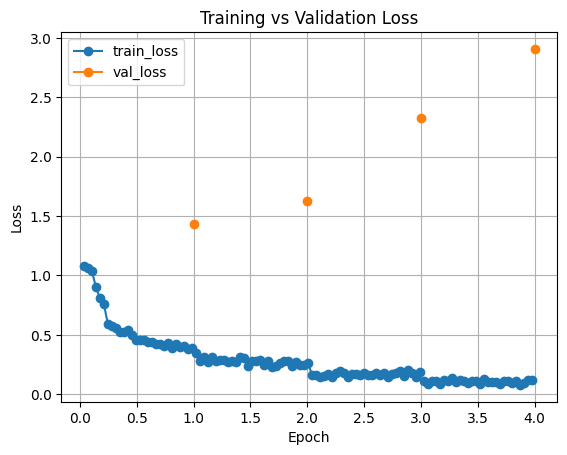

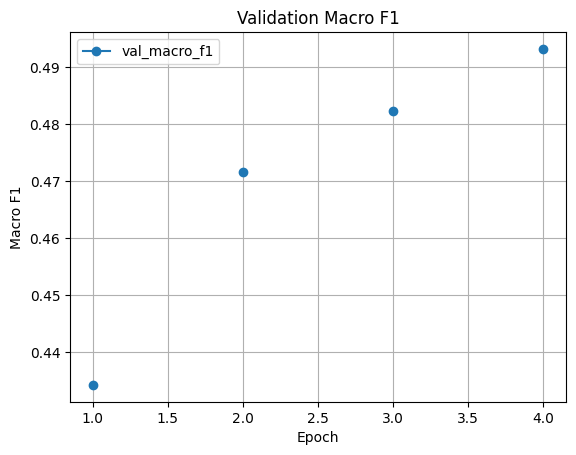

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# logs from Trainer
logs = pd.DataFrame(trainer.state.log_history)

# Aggregate per-epoch metrics
ep = logs.dropna(subset=["epoch"]).groupby("epoch").agg({
    "loss":"last",
    "eval_loss":"last",
    "eval_accuracy":"last",
    "eval_macro_f1":"last"
}).reset_index()

display(ep)

# Loss
plt.figure()
plt.plot(ep["epoch"], ep["loss"], marker='o', label="train_loss")
plt.plot(ep["epoch"], ep["eval_loss"], marker='o', label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.grid(True)
plt.savefig("outputs_loss_curve.png", dpi=150)
plt.show()

# Macro-F1
plt.figure()
plt.plot(ep["epoch"], ep["eval_macro_f1"], marker='o', label="val_macro_f1")
plt.xlabel("Epoch"); plt.ylabel("Macro F1"); plt.title("Validation Macro F1")
plt.legend(); plt.grid(True)
plt.savefig("outputs_f1_curve.png", dpi=150)
plt.show()

## Classification Report


=== Dev classification report ===
               precision    recall  f1-score   support

   entailment     0.4786    0.5030    0.4905       334
      neutral     0.5170    0.5465    0.5314       333
contradiction     0.4646    0.4144    0.4381       333

     accuracy                         0.4880      1000
    macro avg     0.4868    0.4880    0.4867      1000
 weighted avg     0.4868    0.4880    0.4867      1000



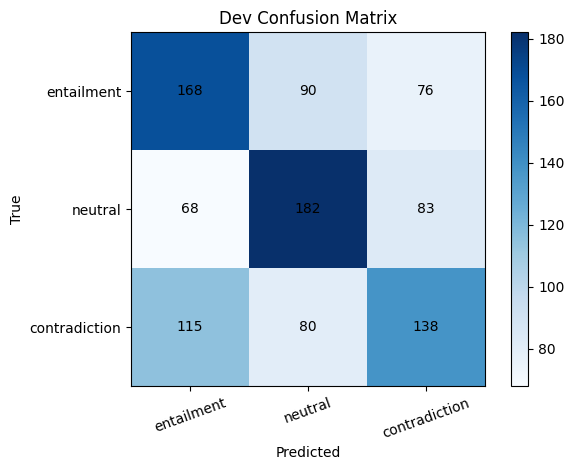


=== Test classification report ===
               precision    recall  f1-score   support

   entailment     0.4879    0.5449    0.5149       334
      neutral     0.4939    0.4895    0.4917       333
contradiction     0.5017    0.4474    0.4730       333

     accuracy                         0.4940      1000
    macro avg     0.4945    0.4939    0.4932      1000
 weighted avg     0.4945    0.4940    0.4932      1000



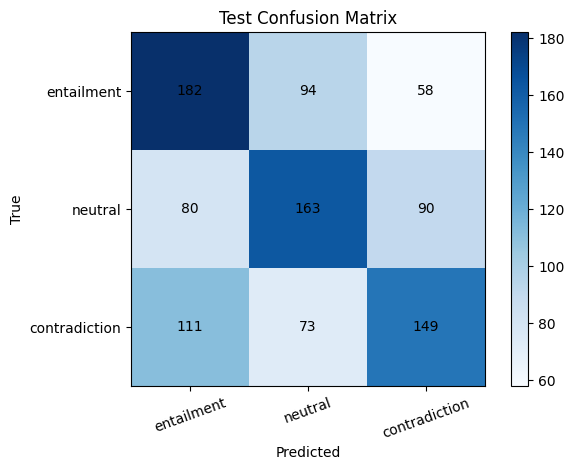

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

label_names = ["entailment","neutral","contradiction"]

def eval_split(ds_tok, split_name):
    pred = trainer.predict(ds_tok)
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)

    print(f"\n=== {split_name} classification report ===")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(ticks=range(3), labels=label_names, rotation=20)
    plt.yticks(ticks=range(3), labels=label_names)
    for i in range(3):
        for j in range(3):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f"outputs_confmat_{split_name.lower()}.png", dpi=150)
    plt.show()

eval_split(ds_val_tok, "Dev")
eval_split(ds_test_tok, "Test")

In [ ]:
# Colab Cell

# # Zip and download plots + model dir if needed 
# !mkdir -p outputs
# !cp outputs_*.png outputs/ 2>/dev/null || true
# !zip -r artifacts.zip models/deberta-v3-anli-r2 outputs_*.png outputs_confmat_*.png 2>/dev/null || true

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


zsh:1: no matches found: outputs_*.png


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


zsh:1: no matches found: outputs_*.png


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Inference / Using trained model to predict

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_dir = "../artifacts/models/deberta-v3-anli-r2"
tok = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
model.eval()

def predict(premise, hypothesis):
    inputs = tok(premise, hypothesis, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = torch.argmax(logits, dim=1).item()
    return model.config.id2label[pred]

print(predict("A man is playing guitar.", "A person is making music."))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


entailment


## Script to upload model to Hugging Face

In [ ]:
from huggingface_hub import HfApi
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os

LOCAL_MODEL_DIR = "../artifacts/models/deberta-v3-anli-r2"   
REPO_ID         = "BakshiSan/deberta-v3-anli-r2" 

print("Loading model from disk...")
tok = AutoTokenizer.from_pretrained(LOCAL_MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(LOCAL_MODEL_DIR)
print("Model loaded.")

api = HfApi()

print("Ensuring repo exists...")
api.create_repo(repo_id=REPO_ID, repo_type="model", exist_ok=True)
print("Repo ready.")

print("Starting upload_folder... this can take a while for a 700MB model.")
api.upload_folder(
    folder_path=LOCAL_MODEL_DIR,
    repo_id=REPO_ID,
    commit_message="Upload fine-tuned DeBERTa-v3 ANLI-R2 model"
)
print("Upload complete")